In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Flatten ,Dropout
import tensorflow as tf
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_auc_score, roc_curve, auc ,accuracy_score,precision_score,recall_score,f1_score,accuracy_score

In [2]:
image_size = 32
num_channels = 3
num_features = image_size * image_size * num_channels
num_classes = 10

num_train = 49000

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Train data shape: {}'.format(X_train.shape))
print('Test  data shape: {}'.format(X_test.shape))

Train data shape: (50000, 32, 32, 3)
Test  data shape: (10000, 32, 32, 3)


In [4]:
def visualize_samples(dataset, labels, samples_per_class=2):
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    plt.figure(figsize=(16, 8))

    for cls, name in enumerate(class_names):
        idxs = np.flatnonzero(labels == cls)
        idxs = np.random.choice(idxs, samples_per_class, replace=False)
        for i, idx in enumerate(idxs):
            plt.subplot(samples_per_class, num_classes, i * num_classes + cls + 1)
            plt.imshow(dataset[idx], interpolation='spline16')
            plt.axis('off')
            if i == 0:
                plt.title(class_names[cls])

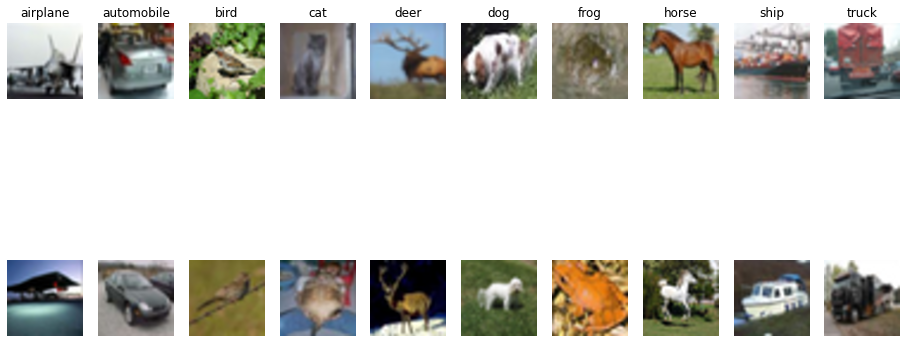

In [5]:
visualize_samples(X_train, y_train)

In [5]:
# convert pixel range from [0, 255] to [0., 1.]
#X_test = datagen.standardize(X_test)
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')

# rescale all image values to lie in 0-1
X_train /= 255.0
# 0 is batch dimension, that is, the whole dataset, 1, and 2 are width and height of the images
# we are basically saying, calculate the mean/std, all the images (withxheight) in the whole dataset
mean = np.mean(X_train, axis=(0, 1, 2))
std = np.std(X_train, axis=(0, 1, 2))
X_train = (X_train - mean) / std

X_test /= 255.0
X_test =(X_test-mean) / std

print(X_train.shape)
print(X_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [7]:
#mean = [0.5071, 0.4867, 0.4408]
#std = [0.2675, 0.2565, 0.2761]
#for i in range(3):
    #X_train[:, :, :, i] = X_train[:, :, :, i] - mean[i]
    #X_train[:, :, :, i] = X_train[:, :, :, i] / std[i]
    #X_test[:, :, :, i] = X_test[:, :, :, i] - mean[i]
    #X_test[:, :, :, i] = X_test[:, :, :, i] / std[i]

In [6]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test  = keras.utils.to_categorical(y_test,  num_classes)

print(y_train.shape)
print(y_test.shape)

(50000, 10)
(10000, 10)


In [7]:
npad = ((0,0), (4,4), (4,4), (0,0))
X_train = np.pad(X_train, pad_width=npad, mode='constant', constant_values=0)
X_test = np.pad(X_test, pad_width=npad, mode='constant', constant_values=0)

In [8]:
def augment(X_train):#کدی که از داکیومنت تنسورفلو پیدا کردم
  X_train = tf.image.random_crop(X_train, size=[40, 40, 3])
  
  return X_train 

In [9]:
    datagen = ImageDataGenerator(
        horizontal_flip=True, 
        preprocessing_function = augment
        )

In [10]:
datagen.fit(X_train[:num_train])

IndexError: ignored

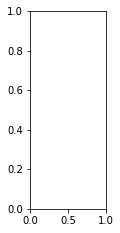

In [13]:
visualize_samples(X_train, y_train)#این خطا رو بهم میده 
#index 337253 is out of bounds for axis 0 with size 50000

In [11]:
# plotting helper function
def plothist(hist):
    
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')


    plt.show()

In [12]:
def create_cnn():
    model = Sequential()
    # Conv Block 1
    model.add(Conv2D(64, (3, 3), padding='same' , strides=(1, 1), input_shape=X_train.shape[1:]))
    model.add(BatchNormalization(momentum=0.05,trainable=True, epsilon=1e-05))# affine=True, track_running_stats=True
    model.add(Activation(activation='relu'))#(inplace)

    model.add(Conv2D(128, (3, 3), padding='same',strides=(1, 1),))
    model.add(BatchNormalization(momentum=0.05, epsilon=1e-05))
    model.add(Activation(activation='relu'))#(inplace)

    model.add(Conv2D(128, (3, 3), padding='same',strides=(1, 1)))
    model.add(BatchNormalization(momentum=0.05, epsilon=1e-05))
    model.add(Activation(activation='relu'))#(inplace)
     
    model.add(Conv2D(128, (3, 3), padding='same',strides=(1, 1)))
    model.add(BatchNormalization(momentum=0.05, epsilon=1e-05))
    model.add(Activation(activation='relu'))#(inplace)
     
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))# padding=0, dilation=(1, 1), ceil_mode=False)
    model.add(Dropout(0.1))          


    # Conv Block 2
    model.add(Conv2D(128, (3, 3), padding='same',strides=(1, 1)))
    model.add(BatchNormalization(momentum=0.05, epsilon=1e-05))
    model.add(Activation(activation='relu'))#(inplace)

    model.add(Conv2D(128, (3, 3), padding='same',strides=(1, 1)))
    model.add(BatchNormalization(momentum=0.05, epsilon=1e-05))
    model.add(Activation(activation='relu'))#(inplace)

    model.add(Conv2D(256, (3, 3), padding='same',strides=(1, 1)))
    model.add(BatchNormalization(momentum=0.05, epsilon=1e-05))
    model.add(Activation(activation='relu'))#(inplace)
     
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))# padding=0, dilation=(1, 1), ceil_mode=False)
    model.add(Dropout(0.1))


    # Conv Block 3
    model.add(Conv2D(256, (3, 3), padding='same',strides=(1, 1)))
    model.add(BatchNormalization(momentum=0.05, epsilon=1e-05))
    model.add(Activation(activation='relu'))#(inplace)

    model.add(Conv2D(256, (3, 3), padding='same',strides=(1, 1)))
    model.add(BatchNormalization(momentum=0.05, epsilon=1e-05))
    model.add(Activation(activation='relu'))#(inplace)
     
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))# padding=0, dilation=(1, 1), ceil_mode=False)
    model.add(Dropout(0.1))

    # Conv Block 4
    model.add(Conv2D(512, (3, 3), padding='same',strides=(1, 1)))
    model.add(BatchNormalization(momentum=0.05, epsilon=1e-05))
    model.add(Activation(activation='relu'))#(inplace)
     
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))# padding=0, dilation=(1, 1), ceil_mode=False)
    model.add(Dropout(0.1))

    # Conv Block 5
    model.add(Conv2D(2048, (1, 1), padding='same',strides=(1, 1)))
    model.add(BatchNormalization(momentum=0.05, epsilon=1e-05))
    model.add(Activation(activation='relu'))#(inplace)

    model.add(Conv2D(256, (1, 1), padding='same',strides=(1, 1)))
    model.add(BatchNormalization(momentum=0.05, epsilon=1e-05))
    model.add(Activation(activation='relu'))#(inplace)
     
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))# padding=0, dilation=(1, 1), ceil_mode=False)
    model.add(Dropout(0.1))


    # Conv Block 6
    model.add(Conv2D(256, (3, 3), padding='same',strides=(1, 1)))
    model.add(BatchNormalization(momentum=0.05, epsilon=1e-05))
    model.add(Activation(activation='relu'))#(inplace)


    # Classifier
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))

    return model

model = create_cnn()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 40, 40, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 40, 40, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 40, 40, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 40, 40, 128)       512       
_________________________________________________________________
activation_1 (Activation)    (None, 40, 40, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 128)       1

In [13]:
BATCH_SIZE =100
STEPS_PER_EPOCH =len(X_train)//BATCH_SIZE 

step = tf.Variable(0, trainable=False)
boundaries = [10*STEPS_PER_EPOCH,20*STEPS_PER_EPOCH,
              50*STEPS_PER_EPOCH,70*STEPS_PER_EPOCH,
              90*STEPS_PER_EPOCH]
values = [0.1, 0.01 , 0.001, 0.0001,0.00001,0.000001]
learning_rate_fn = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries, values)

In [14]:
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate_fn)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
weight_decay= 0.002

In [16]:
# a utility function to add weight decay after the model is defined.
def add_weight_decay(model, weight_decay):
    if (weight_decay is None) or (weight_decay == 0.0):
        return

    # recursion inside the model
    def add_decay_loss(m, factor):
        if isinstance(m, tf.keras.Model):
            for layer in m.layers:
                add_decay_loss(layer, factor)
        else:
            for param in m.trainable_weights:
                with tf.keras.backend.name_scope('weight_regularizer'):
                    regularizer = lambda: tf.keras.regularizers.l2(factor)(param)
                    m.add_loss(regularizer)

    # weight decay and l2 regularization differs by a factor of 2
    add_decay_loss(model, weight_decay/2.0)
    return

In [17]:
#history =model.fit(X_train[:num_train], y_train[:num_train],batch_size=90,epochs=10,validation_data=(X_train[num_train:], y_train[num_train:]))

In [18]:
history =model.fit(datagen.flow(X_train[:num_train], y_train[:num_train], batch_size=64),
                        epochs=10,
                        validation_data=(X_train[num_train:], y_train[num_train:]))

Epoch 1/10
766/766 [==============================] - 113s 147ms/step - loss: 1.4106 - accuracy: 0.4895 - val_loss: 0.9175 - val_accuracy: 0.6870
Epoch 2/10
766/766 [==============================] - 113s 147ms/step - loss: 0.8430 - accuracy: 0.7024 - val_loss: 0.7658 - val_accuracy: 0.7330
Epoch 3/10
766/766 [==============================] - 112s 146ms/step - loss: 0.6593 - accuracy: 0.7678 - val_loss: 0.6144 - val_accuracy: 0.7930
Epoch 4/10
766/766 [==============================] - 112s 146ms/step - loss: 0.5569 - accuracy: 0.8063 - val_loss: 0.5571 - val_accuracy: 0.8140
Epoch 5/10
766/766 [==============================] - 112s 147ms/step - loss: 0.4838 - accuracy: 0.8317 - val_loss: 0.5088 - val_accuracy: 0.8300
Epoch 6/10
766/766 [==============================] - 111s 145ms/step - loss: 0.4265 - accuracy: 0.8532 - val_loss: 0.4239 - val_accuracy: 0.8660
Epoch 7/10
766/766 [==============================] - 111s 146ms/step - loss: 0.3541 - accuracy: 0.8768 - val_loss: 0.4027 -

In [ ]:
model.save('cifar10.simplenet2.h5')
                 
#model=load_model('cifar10_01.h5')

In [19]:
y_pred = model.predict(X_test)
labels1 = np.arange(num_classes)
print('Auc = %f' %  (roc_auc_score(y_test,  y_pred.round(),average='macro',multi_class='ovo',labels=labels1)))
print('f1_score = %f' % (f1_score(y_test, y_pred.round(), average="macro")))
print('precision = %f' % (precision_score(y_test, y_pred.round(), average="macro")))
print('recall  = %f' % (recall_score(y_test, y_pred.round(), average="macro")))
print('accuracy  = %f' % (accuracy_score(y_test, y_pred.round())))  

Auc = 0.923333
f1_score = 0.872799
precision = 0.893079
recall  = 0.858100
accuracy  = 0.858100


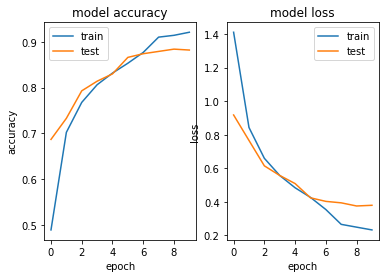

In [20]:
plothist(history)